# Introduction to Experiment

### 1. **Start**

- 更新server： `quark update --server`

- 更新studio： `quark update --studio`

In [9]:
import matplotlib.pyplot as plt
import numpy as np

from quark.app import Recipe, s, submit

1. 将cfg表（如[checkpoint.json](../checkpoint.json)）复制到： **~/Desktop/home/cfg**(如目录不存在可自行创建)


2. 如果重启server需要重新login

In [10]:
# 每次重启server都需要重新login，用户名与注册时保持一致
s.login('baqis')

# 如果login提示错误，则执行注册操作：signup
# 用户名任意(此处为baqis)，用于login
# 此为一次性操作，除非更改cfg文件名或用户名
# signup完毕后重新login即可
# s.signup('baqis','checkpoint')

[2025-03-18 17:01:32.684][QuarkServer][CRITICAL💀] @SEND: NoneType[WinError 10054] 远程主机强迫关闭了一个现有的连接。


2025-03-18 17:01:32.924 | INFO     | quark.app:login:128 - LOGINED[baqis], Checkpoint[2025-03-18 17:00:06 Tue] loaded from: C:\Users\drice\Desktop\home\cfg\checkpoint.ckpt


3. 设置Recipe，**此为全局设置**

In [11]:
def get_all_channels(cfg: dict[str, dict] = {}):
    cfg = s.snapshot() if not cfg else cfg

    init = []
    for k, v in cfg.items():
        if not k.startswith(('Q', 'C', 'M')):
            continue

        init.append((f'{k}.waveform.DDS', 'zero()'))
        # init.append((f'{k}.waveform.Z', 'zero()'))

    return init


def before_the_task(shots: int):
    # 任务开始之前执行的设置，根据实际情况填写
    return [('QSync.CH1.Shot', shots)]


def precompile(shots: int):
    # 编译开始前的设置，通常用于将所有通道置零
    return get_all_channels()


def after_the_task(shots: int):
    # 任务结束之后执行的设置，根据实际情况填写
    return get_all_channels()


Recipe.align_right = False
Recipe.waveform_length = 98e-6

Recipe.initialize = before_the_task
Recipe.precompile = precompile
Recipe.finalize = after_the_task

4. 打开设备，在此之前，任务不可执行！

In [12]:
s.start()

'QuarkServer started!'

### 2. **FAQ?**
***遇到问题先看错误信息！遇到问题先看错误信息！遇到问题先看错误信息！***
1. 设备没有正常开启？
- 检查`etc.driver.path`是否正确，一般为`systemq/dev`或`dev`！
- 设备`type`为`remote`时，检查设备名字、`host`和`port`是否和设备的ip和端口匹配！

2. 线路编译错误？
- 检查线路编写是否有误！
- 检查`lib.gates.__init__`中导入的门模块是否正确，或cfg表中填写的参数是否匹配！

3. 实验没有数据或采集设备显示超时？
- 检查触发设备`shots`设置和采集设备设置是否一致！

4. 波形下发错误？
- 检查设备上的numpy（**大**版本同为1.x.x或2.x.x）和waveforms版本和测量电脑是否一致！

### 3. **Device**

#### driver测试

In [ ]:
# 根据设备类型导入设备驱动
from systemq.dev import NetworkAnalyzer

# 根据设备地址实例化设备
dev = NetworkAnalyzer.Driver('192.168.1.42')
# 打开设备
dev.open()

# 设备写操作，可操作属性见驱动文件定义的quants列表
dev.setValue('Power', -10)
# 设备读操作，可操作属性见驱动文件定义的quants列表
dev.getVaule('Power')

#### remote更新
适用于从测量电脑更新设备上的python库

In [ ]:
from quark.app import update_remote_wheel

# 需要将相应的库下载到本地，并将路径传与index参数
update_remote_wheel('waveforms', index='.', host='127.0.0.1')

### 4. **History**

In [ ]:
from quark.app import lookup
lookup(start='2024-10-09', end='2025-12-01', name='')

In [33]:
from quark.app import get_config_by_rid, get_data_by_rid, get_tid_by_rid, diff, rollback

# 根据rid获取数据
# get_data_by_rid(238)

# 根据rid获取cfg
# get_config_by_rid(238)

# 根据rid查询tid
# get_tid_by_rid(123)

# 回滚到指定rid的cfg
# rollback(238)

# 根据rid对比新旧两次任务间cfg的变化
# diff(41, 1)

### 5. **Compiler**

适用于在本地测试线路正确性，**无需server**

In [33]:
# 关于编译/波形采样/数据处理相关的函数逻辑, 详见
from quark.interface import Workflow

from quark.app import translate, preview

In [34]:
import json

# cfg = get_config_by_rid(238) # 获取历史cfg表

# 从文件中读取cfg表
with open('checkpoint.json', 'r') as f:
    cfg = json.loads(f.read())

for q in ['Q3', 'Q4']:
    cfg['gate']['Measure'][q]['default_type'] = 'default'

2025-02-28 10:21:37.483 | INFO     | quark.runtime.assembler:ccompile:88 - >>>>>>>>>>>>>>>>>>>>>>>> Step 0 is compiled!


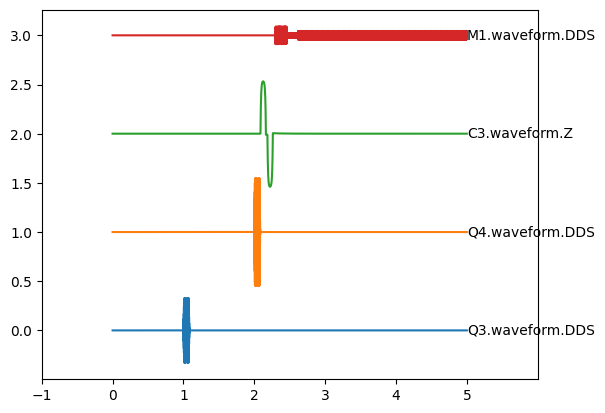

In [ ]:
circuit = [(('Delay', 1e-6), 'Q3'),
           ('X', 'Q3'),
           (('Delay', 2e-6), 'Q4'),
           ('H', 'Q4'),
           ('Barrier', ('Q3', 'Q4')),
           ('CZ', ('Q3', 'Q4')),
           (('Measure', 0), 'Q3'),
           (('Measure', 1), 'Q4')
           ]

ctx, (cmds, dmap) = translate(circuit,
                              cfg=cfg,
                              # lib='systemq.lib.gates.cz_v4',
                              align_right=False)
wf = preview(cmds['main'], srate=10e9, end=5e-6, offset=1, space=1)

### 6. **NetworkAnalyzer**
- **在dev中添加名为 NA 的网分**

#### S21(NA)

In [ ]:
rcp = Recipe('NAS21', signal='S')
rcp.circuit = [[(('GET', rcp.signal), 'NA.CH1')]]

rcp['NA.CH1.FrequencyStart'] = 6.85 * 1e9
rcp['NA.CH1.FrequencyStop'] = 7e9
rcp['NA.CH1.NumberOfPoints'] = 5001
rcp['NA.CH1.Bandwidth'] = 500

rcp['power'] = -50
rcp['NA.CH1.Power'] = rcp['power']

tt = submit(rcp.export())
tt.bar(interval=0.1)

baqis:/NAS21   0%|          |0/1 [00:00<?, ?it/s, MainThread]

(array([6.86680e+09, 6.89764e+09, 6.95566e+09, 6.98608e+09]),
 array([-31.47635107, -32.70408656, -28.68949135, -28.69484137]))

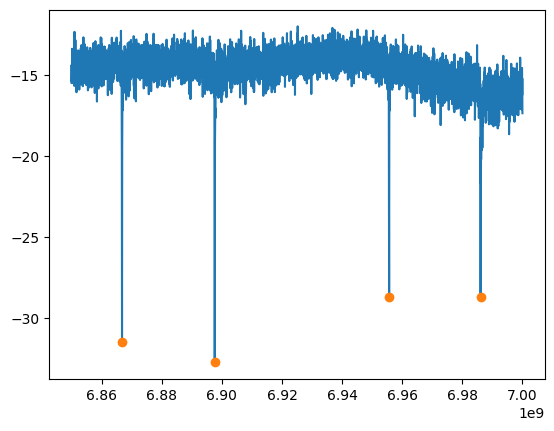

In [ ]:
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
r = np.asarray(tt.result()['S'])
freq = s.read('NA.CH1.Frequency')['NA']['CH1.Frequency']


S21_in_dB = 20 * np.log10(np.abs(r)).squeeze()
peaks, _ = find_peaks(-S21_in_dB, height=20, distance=100)
x, y = freq[peaks], S21_in_dB[peaks]

plt.plot(freq, S21_in_dB)
plt.plot(x, y, 'o')
x, y

#### S21vsPower(NA)

In [ ]:
rcp = Recipe('NAS21vsPower', signal='S')
rcp.circuit = [[(('GET', rcp.signal), 'NA.CH1')]]

rcp['NA.CH1.FrequencyStart'] = 6.85 * 1e9
rcp['NA.CH1.FrequencyStop'] = 7e9
rcp['NA.CH1.NumberOfPoints'] = 5001

rcp['power'] = np.linspace(-60, 0, 26)
rcp['NA.CH1.Power'] = rcp['power']

tt = submit(rcp.export())
tt.bar()

baqis:/NAS21   0%|          |0/26 [00:00<?, ?it/s, MainThread]

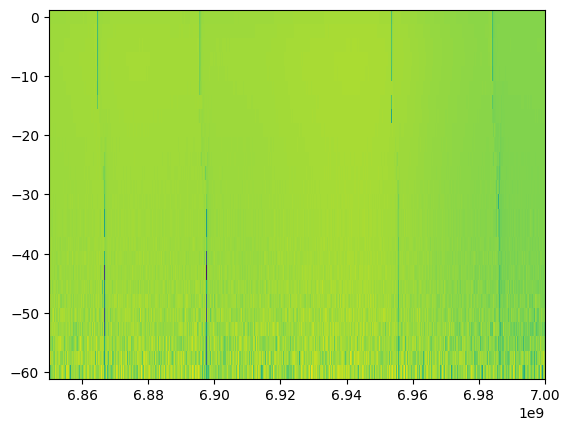

In [ ]:
r = np.asarray(tt.result()['S'])
freq = s.read('NA.CH1.Frequency')['NA']['CH1.Frequency']

plt.pcolormesh(freq, rcp['power'], 20 * np.log10(np.abs(r)))

#### Spectrum(NA)
- **在dev中添加名为 MW 的微波源**

In [ ]:
rcp = Recipe('NASpectrum', signal='S')
rcp.circuit = [[(('GET', rcp.signal), 'NA.CH1')]]

rcp['NA.CH1.FrequencyStart'] = 6.98611e+09
rcp['NA.CH1.FrequencyStop'] = 6.98611e+09
rcp['NA.CH1.NumberOfPoints'] = 5
rcp['NA.CH1.Bandwidth'] = 20

rcp['power'] = -50  # np.linspace(-60,0,26)
rcp['NA.CH1.Power'] = rcp['power']

# 微波源
rcp['freq'] = np.linspace(2, 3, 1001) * 1e9
rcp['MW.CH1.Frequency'] = rcp['freq']
rcp['MW.CH1.Power'] = -20
rcp['MW.CH1.Output'] = 'ON'

tt = submit(rcp.export())
tt.bar()

baqis:/NASpectrum   0%|          |0/1001 [00:00<?, ?it/s, MainThread]

In [ ]:
# tt.cancel()

In [15]:
r = np.asarray(tt.result()['S']).mean(axis=1)

(1001,)

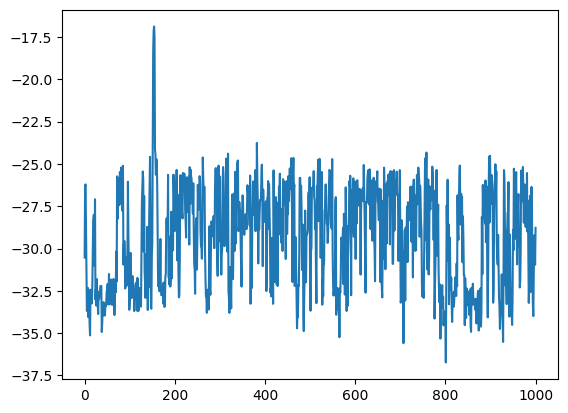

In [16]:
import matplotlib.pyplot as plt

rdb = 20 * np.log10(np.abs(r)).squeeze()
plt.plot(rdb)

### 7. **A/D Converter**
- 导入外部定义的[**circuit**](../circuit/)模块

In [13]:
import circuit as cdemo

#### Trace


In [ ]:
qubits = [f'Q{i}' for i in range(0, 9, 4)]
rcp = Recipe('trace', signal='trace')
rcp.circuit = cdemo.S21

rcp['qubits'] = tuple(qubits)
rcp['freq'] = np.linspace(-5, 5, 3) * 1e6

for q in qubits:
    rcp[f'gate.Measure.{q}.params.frequency'] = rcp['freq'] + \
        s.query(f'gate.Measure.{q}.params.frequency')
    rcp[f'gate.Measure.{q}.default_type'] = 'default'

trace = submit(rcp.export(), preview=[])
trace.bar(interval=1)

baqis:/trace   0%|          |0/3 [00:00<?, ?it/s, MainThread]

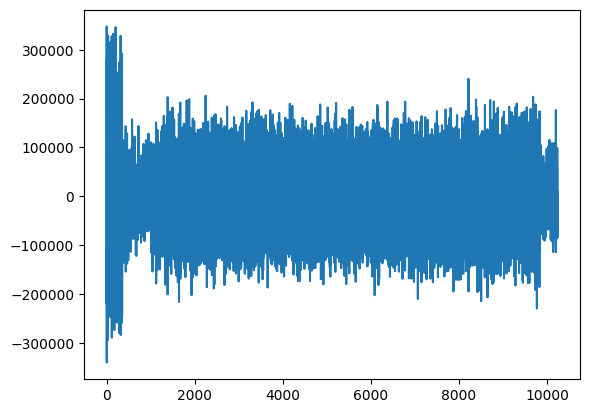

In [ ]:
tr = trace.result()['data']['trace']
plt.plot(tr[0, :, 0])

#### S21


In [14]:
qubits = [f'Q{i}' for i in range(0, 9, 4)]
rcp = Recipe('s21', signal='iq_avg')
rcp.circuit = cdemo.S21

rcp['qubits'] = tuple(qubits)
rcp['freq'] = np.linspace(-5, 5, 101) * 1e6

for q in qubits:
    rcp[f'gate.Measure.{q}.params.frequency'] = rcp['freq'] + \
        s.query(f'gate.Measure.{q}.params.frequency')
    rcp[f'gate.Measure.{q}.default_type'] = 'default'

s21 = submit(rcp.export(), preview=[])
s21.bar(interval=1)

baiqs:/s21   0%|          |0/101 [00:00<?, ?it/s, MainThread]

##### circuit

In [11]:
cirq = s21.circuit(0)
cirq

[(('Measure', 0), 'Q0'), (('Measure', 1), 'Q4'), (('Measure', 2), 'Q8')]

##### commands

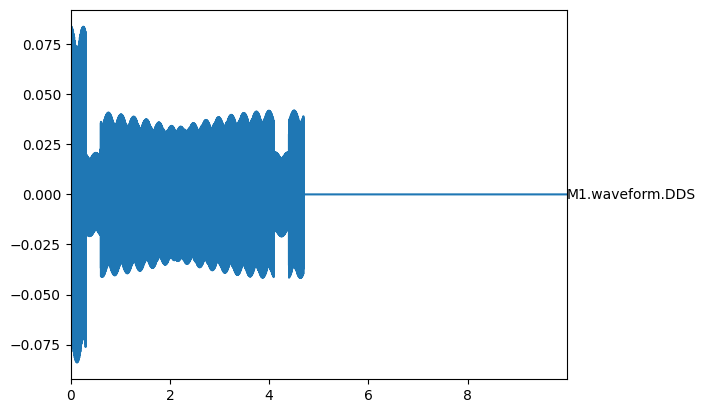

In [14]:
cmds = s21.step(0)
wfv = preview(cmds['main'], start=0, end=10e-6, srate=5e9)

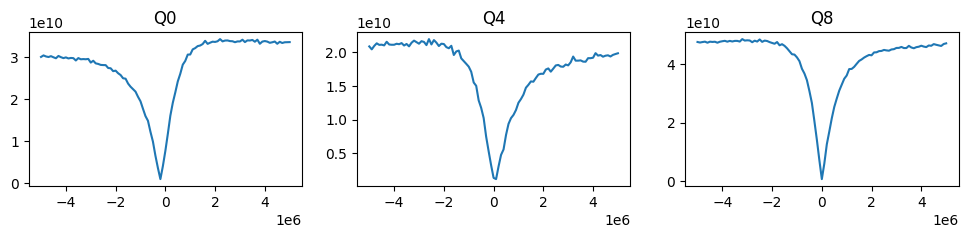

In [16]:
rs = s21.result()
signal = rs['meta']['other']['signal'].split('|')[0]

r = np.asarray(rs['data'][signal])
ax = plt.subplots(1, 3, figsize=(12, 2))[1].flatten()
for i, q in enumerate(qubits):
    fq = rs['meta']['axis']['freq']['def']
    rq = np.abs(r)[:, i]
    ax[i].plot(fq, rq)

    ax[i].set_title(f'{q}')

#### Spectrum

##### Spectrum

In [ ]:
qubits = [f'Q{i}' for i in range(0, 9, 4)]
rcp = Recipe('spectrum', signal='remote_iq_avg')
rcp.circuit = cdemo.Spectrum

rcp['qubits'] = tuple(qubits)
rcp['freq'] = np.linspace(-50, 50, 101) * 1e6

for q in qubits:
    rcp[f'gate.R.{q}.params.frequency'] = rcp['freq'] + \
        s.query(f'gate.R.{q}.params.frequency')
    rcp[f'gate.R.{q}.params.amp'] = 0.1
    rcp[f'gate.R.{q}.params.width'] = 100e-9
    rcp[f'gate.R.{q}.params.delta'] = 0
    rcp[f'gate.R.{q}.params.plateau'] = 0e-6
    rcp[f'gate.Measure.{q}.default_type'] = 'default'

spec = submit(rcp.export(), preview=[])
spec.bar()

baqis:/spectrum   0%|          |0/101 [00:00<?, ?it/s, MainThread]

In [73]:
spec.cancel()

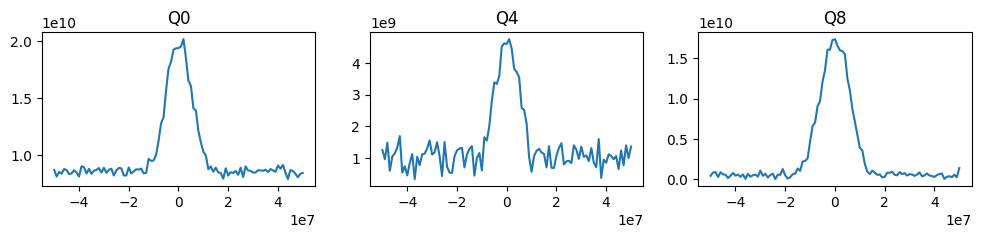

In [75]:
rs = spec.result()
signal = rs['meta']['other']['signal'].split('|')[0]

r = np.asarray(rs['data'][signal])
ax = plt.subplots(1, 3, figsize=(12, 2))[1].flatten()
for i, q in enumerate(qubits):
    fq = rs['meta']['axis']['freq']['def']
    rq = np.abs(r)[:, i]
    ax[i].plot(fq, rq)

    ax[i].set_title(f'{q}')

##### Spectrum12

In [ ]:
def Spectrum12(qubits: tuple[str], act_qubits: list[str] = None, ctx=None) -> list:
    act_qubits = qubits if act_qubits is None else act_qubits

    cc = [
        *[(('R', 0), q) for q in act_qubits] * 2,
        *[(('R12', 0), q) for q in act_qubits] * 2,
        *[(('R', 0), q) for q in act_qubits] * 2,
        ('Barrier', tuple(qubits)),
        *[(('Measure', j), q) for j, q in enumerate(qubits)],
    ]
    return cc

In [ ]:

qubits = [f'Q{i}' for i in range(0, 9, 4)]
rcp = Recipe('spectrum', signal='iq_avg')
rcp.circuit = Spectrum12

rcp['qubits'] = tuple(qubits)
rcp['freq'] = np.linspace(-50, 50, 11) * 1e6

for q in qubits:
    rcp[f'gate.R12.{q}.params.frequency'] = rcp['freq'] + \
        s.query(f'gate.R12.{q}.params.frequency')
    rcp[f'gate.R12.{q}.params.amp'] = 0.02
    rcp[f'gate.R12.{q}.params.width'] = 1e-7
    rcp[f'gate.R12.{q}.params.delta'] = 0
    # rcp[f'gate.R12.{q}.params.plateau']= 0e-6
    rcp[f'gate.Measure.{q}.default_type'] = 'default'

spec = submit(rcp.export(), preview=[])
spec.bar()

baiqs:/spectrum   0%|          |0/11 [00:00<?, ?it/s, MainThread]

In [28]:
spec.cancel()

In [77]:
# cmds = spec.step(0)
# wfv = preview(cmds['main'], start=0, end=10e-6, srate=5e9,offset=1)

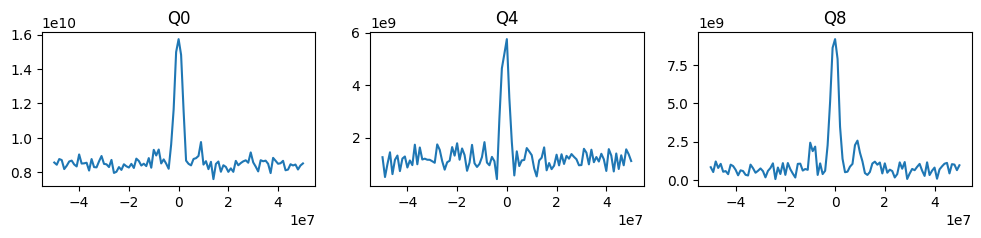

In [93]:
rs = spec.result()
signal = rs['meta']['other']['signal'].split('|')[0]

r = np.asarray(rs['data'][signal])
ax = plt.subplots(1, 3, figsize=(12, 2))[1].flatten()
for i, q in enumerate(qubits):
    fq = rs['meta']['axis']['freq']['def']
    rq = np.abs(r)[:, i]
    ax[i].plot(fq, rq)

    ax[i].set_title(f'{q}')

#### Rabi

##### PowerRabi

In [ ]:
def PowerRabi(qubits: tuple[str], n: int = 1, act_qubits: tuple[str] = None, ctx=None):
    act_qubits = qubits if act_qubits is None else act_qubits

    cc = [*[(('R', 0), q) for q in act_qubits] * (2 * n),
          ('Barrier', tuple(qubits)),
          *[(('Measure', j), q) for j, q in enumerate(qubits)],
          ]
    return cc


def TimeRabi(qubits: tuple[str], act_qubits: tuple[str] = None, ctx=None):
    act_qubits = qubits if act_qubits is None else act_qubits

    cc = [*[(('R', 0), q) for q in act_qubits] * 2,
          ('Barrier', tuple(qubits)),
          *[(('Measure', j), q) for j, q in enumerate(qubits)],
          ]
    return cc

In [ ]:
qubits = [f'Q{i}' for i in range(0, 9, 4)]
rcp = Recipe('TimeRabi', signal='iq_avg')

rcp.circuit = PowerRabi

rcp['qubits'] = tuple(qubits)
rcp['amp'] = np.linspace(0, 1, 21)

for q in qubits:
    # rcp[f'gate.R.{q}.params.plateau'] = rcp['delay']
    rcp[f'gate.R.{q}.params.amp'] = rcp['amp']

powerrabi = submit(rcp.export(), preview=[])
powerrabi.bar()

baqis:/TimeRabi   0%|          |0/21 [00:00<?, ?it/s, MainThread]

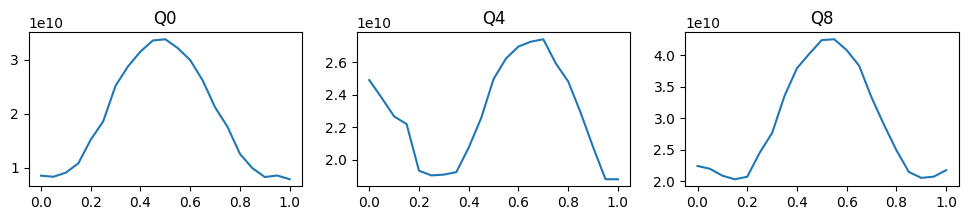

In [ ]:
rs = powerrabi.result()
signal = rs['meta']['other']['signal'].split('|')[0]

r = np.asarray(rs['data'][signal])
ax = plt.subplots(1, 3, figsize=(12, 2))[1].flatten()
for i, q in enumerate(qubits):
    fq = rs['meta']['axis']['amp']['def']
    rq = np.abs(r)[:, i]
    ax[i].plot(fq, rq)

    ax[i].set_title(f'{q}')

##### PowerRabi12

In [ ]:
def PowerRabi12(qubits: tuple[str], n: int = 1, act_qubits: tuple[str] = None, ctx=None):
    act_qubits = qubits if act_qubits is None else act_qubits

    cc = [*[(('R', 0), q) for q in act_qubits] * (2 * n),
          *[(('R12', 0), q) for q in act_qubits] * (2 * n),
          *[(('R', 0), q) for q in act_qubits] * (2 * n),
          ('Barrier', tuple(qubits)),
          *[(('Measure', j), q) for j, q in enumerate(qubits)],
          ]
    return cc


def TimeRabi12(qubits: tuple[str], act_qubits: tuple[str] = None, ctx=None):
    act_qubits = qubits if act_qubits is None else act_qubits

    cc = [*[(('R', 0), q) for q in act_qubits] * 2,
          ('Barrier', tuple(qubits)),
          *[(('Measure', j), q) for j, q in enumerate(qubits)],
          ]
    return cc

In [ ]:
qubits = [f'Q{i}' for i in range(0, 9, 4)]
rcp = Recipe('TimeRabi', signal='iq_avg')

rcp.circuit = PowerRabi12

rcp['qubits'] = tuple(qubits)
rcp['amp'] = np.linspace(-0.1, 0.1, 21)

for q in qubits:
    # rcp[f'gate.R.{q}.params.plateau'] = rcp['delay']
    rcp[f'gate.R12.{q}.params.amp'] = rcp['amp'] + \
        s.query(f'gate.R12.{q}.params.amp')

powerrabi = submit(rcp.export(), preview=[])
powerrabi.bar()

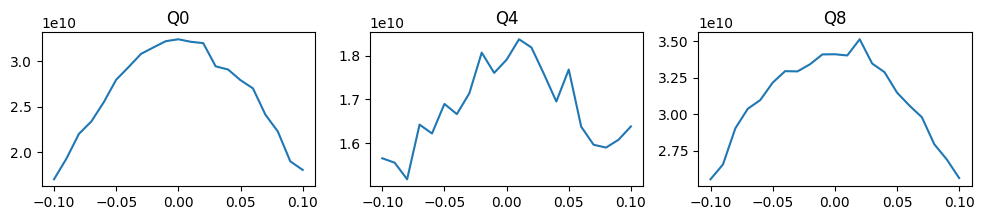

In [ ]:
rs = powerrabi.result()
signal = rs['meta']['other']['signal'].split('|')[0]

r = np.asarray(rs['data'][signal])
ax = plt.subplots(1, 3, figsize=(12, 2))[1].flatten()
for i, q in enumerate(qubits):
    fq = rs['meta']['axis']['amp']['def']
    rq = np.abs(r)[:, i]
    ax[i].plot(fq, rq)

    ax[i].set_title(f'{q}')

#### Scatter


In [ ]:
qubits = [f'Q{i}' for i in range(0, 9, 4)]
rcp = Recipe('Scatter', signal='iq')

rcp.circuit = cdemo.Scatter

rcp['qubits'] = tuple(qubits)
rcp['state'] = ['0', '1']

Scatter = submit(rcp.export(), preview=[])
Scatter.bar(interval=0.1)

baqis:/Scatter   0%|          |0/2 [00:00<?, ?it/s, MainThread]

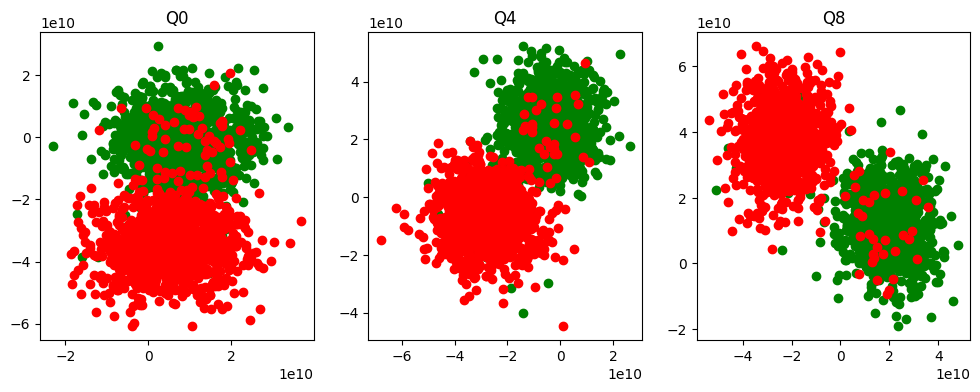

In [ ]:
si, sq = Scatter.result()['data']['iq']

ax = plt.subplots(1, 3, figsize=(12, 4))[1].flatten()
for i, q in enumerate(qubits):
    ax[i].plot(si[:, i].real, si[:, i].imag, 'go')
    ax[i].plot(sq[:, i].real, sq[:, i].imag, 'ro')

    ax[i].set_title(f'{q}')
# plt.plot(i.real, i.imag, 'go')
# plt.plot(q.real, q.imag, 'ro')

#### T1


In [ ]:
qubits = [f'Q{i}' for i in range(0, 9, 4)]
rcp = Recipe('T1', signal='iq_avg')

rcp.circuit = cdemo.T1

rcp['qubits'] = tuple(qubits)
rcp['delay'] = np.linspace(0, 100e-6, 21)

T1 = submit(rcp.export(), preview=[])
T1.bar(interval=1)

baqis:/T1   0%|          |0/21 [00:00<?, ?it/s, MainThread]

In [25]:
T1.cancel()

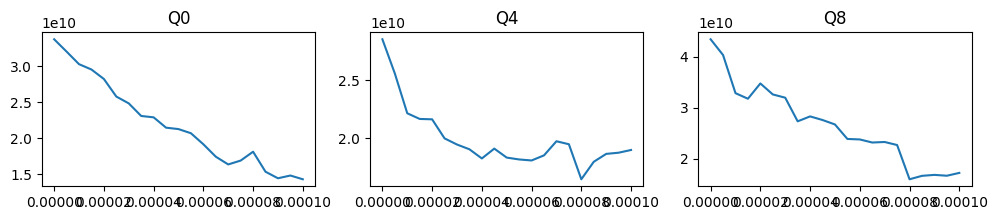

In [22]:
rs = T1.result()
signal = rs['meta']['other']['signal'].split('|')[0]

r = np.asarray(rs['data'][signal])
ax = plt.subplots(1, 3, figsize=(12, 2))[1].flatten()
for i, q in enumerate(qubits):
    fq = rs['meta']['axis']['delay']['def']
    rq = np.abs(r)[:, i]
    ax[i].plot(fq, rq)

    ax[i].set_title(f'{q}')

#### Ramsey


##### Ramsey


In [ ]:
qubits = [f'Q{i}' for i in range(0, 9, 4)]
rcp = Recipe('Ramsey', signal='population')

rcp.circuit = cdemo.Ramsey

rcp['qubits'] = tuple(qubits)

rcp['repeat'] = 1  # np.arange(11)
rcp['delay'] = np.linspace(0, 5e-6, 101)
rcp['rotate'] = 2e6

ramsey = submit(rcp.export(), preview=[])
ramsey.bar()

baqis:/Ramsey   0%|          |0/101 [00:00<?, ?it/s, MainThread]

In [51]:
ramsey.cancel()

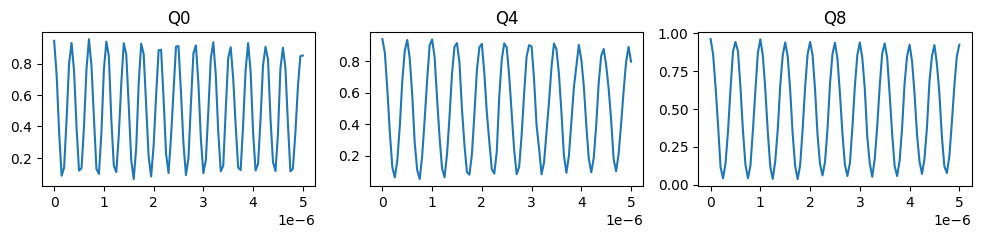

In [25]:
rs = ramsey.result()
signal = rs['meta']['other']['signal'].split('|')[0]

r = np.asarray(rs['data'][signal])
ax = plt.subplots(1, 3, figsize=(12, 2))[1].flatten()
for i, q in enumerate(qubits):
    fq = rs['meta']['axis']['delay']['def']
    rq = np.abs(r)[:, i]
    ax[i].plot(fq, rq)

    ax[i].set_title(f'{q}')

##### Ramsey12


In [ ]:
def Ramsey12(qubits: list[str], delay: float, rotate: float,
             act_qubits=None, ctx=None) -> list:

    import numpy as np

    act_qubits = qubits
    cc = [*[(('R', 0), q) for q in act_qubits],
          *[(('R12', 0), q) for q in act_qubits],
          *[(('Delay', delay), q) for q in act_qubits],
          *[(('R12', 2 * np.pi * rotate * delay), q) for q in act_qubits],
          *[(('R', 0), q) for q in act_qubits],
          ('Barrier', tuple(qubits)),
          *[(('Measure', j), q) for j, q in enumerate(qubits)],
          ]
    return cc

In [ ]:
qubits = [f'Q{i}' for i in range(0, 9, 4)]
rcp = Recipe('Ramsey12', signal='iq_avg')

rcp.circuit = Ramsey12

rcp['qubits'] = tuple(qubits)

rcp['repeat'] = 1  # np.arange(11)
rcp['delay'] = np.linspace(0, 1e-6, 101)
rcp['rotate'] = 10e6

ramsey = submit(rcp.export(), preview=[])
ramsey.bar()

baqis:/Ramsey12   0%|          |0/101 [00:00<?, ?it/s, MainThread]

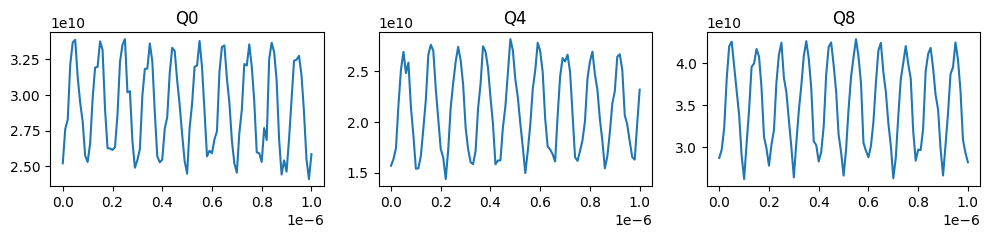

In [101]:
rs = ramsey.result()
signal = rs['meta']['other']['signal'].split('|')[0]

r = np.asarray(rs['data'][signal])
ax = plt.subplots(1, 3, figsize=(12, 2))[1].flatten()
for i, q in enumerate(qubits):
    fq = rs['meta']['axis']['delay']['def']
    rq = np.abs(r)[:, i]
    ax[i].plot(fq, rq)

    ax[i].set_title(f'{q}')

#### SpinEcho


In [ ]:
qubits = ['Q0', 'Q1']
rcp = Recipe('SpinEcho', signal='iq_avg')

rcp.circuit = cdemo.SpinEcho

rcp['qubits'] = tuple(qubits)
rcp['delay'] = np.linspace(0, 10e-6, 51)
rcp['rotate'] = 10e6

echo = submit(rcp.export(), preview=[])
echo.bar()

baqis:/SpinEcho   0%|          |0/51 [00:00<?, ?it/s, MainThread]

In [ ]:
rs = echo.result()
signal = rs['meta']['other']['signal'].split('|')[0]

r = np.asarray(rs['data'][signal])
ax = plt.subplots(1, 2, figsize=(12, 2))[1].flatten()
for i, q in enumerate(qubits):
    fq = rs['meta']['axis']['delay']['def']
    rq = np.abs(r)[:, i]
    ax[i].plot(fq, rq)

    ax[i].set_title(f'{q}')